In [1]:
%reset
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV
import os
from catboost import CatBoostClassifier
import catboost as cb
from sklearn.model_selection import learning_curve


In [2]:
def convert_sample(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.resize(image,[32,32]).numpy()
    image = image.reshape(1,-1)
    return image


file_dir = os.path.realpath(os.path.dirname('__file__'))

In [3]:
ds1,ds2,ds3 = tfds.load('patch_camelyon',split=['train[:20%]','test[:5%]','validation[:5%]'],
                        data_dir = file_dir,
                        download=False,
                        shuffle_files=True,
                        as_supervised=True,
                        batch_size=-1)

In [4]:
train_dataset       = tfds.as_numpy(ds1)
train_dataset_image = np.vstack(list(map(convert_sample,train_dataset[0])))
train_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(train_dataset_image)
train_dataset_label = train_dataset[1].reshape(-1,)    
print(f'Shape of training data features (observations,features): {train_dataset_image_Scaled.shape}')
print(f'Shape of training data labels (observations,): {train_dataset_label.shape}')

validation_dataset  = tfds.as_numpy(ds3)
validation_dataset_image = np.vstack(list(map(convert_sample,validation_dataset[0])))
validation_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(validation_dataset_image)
validation_dataset_label = validation_dataset[1].reshape(-1,) 
   
test_dataset       = tfds.as_numpy(ds2)
test_dataset_image = np.vstack(list(map(convert_sample,test_dataset[0])))
test_dataset_image_Scaled = StandardScaler(with_mean=0, with_std=1).fit_transform(test_dataset_image)
test_dataset_label = test_dataset[1].reshape(-1,)

Shape of training data features (observations,features): (52429, 1024)
Shape of training data labels (observations,): (52429,)


In [ ]:
baseline model
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_dataset_image_Scaled, train_dataset_label)

# baseline accuracy = 70%
y_test_hat = rf.predict(validation_dataset_image_Scaled)
accuracy = accuracy_score(validation_dataset_label, y_test_hat)
print(f'Baseline model accuracy: {round(accuracy * 100, 1)}% accuracy.')

# Finding feature importance
importance = rf.feature_importances_
feature_pd = pd.Series(importance)
feature_importance = feature_pd.sort_values(ascending=False).reset_index()
print(feature_importance[:20])

# vægtningen af alle variabler giver tilsammen 1. De 20 vigtigste giver 0.31
print(sum((feature_importance[0][:10])))

rf.score(validation_dataset_image_Scaled, validation_dataset_label)



In [5]:
#plot Random Forest learning curve with 32*32 images and grayscale

rf_train_sizes, rf_train_scores, rf_valid_scores = learning_curve(RandomForestClassifier(), 
                                                        train_dataset_image_Scaled, 
                                                        train_dataset_label, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=5, 
                                                        scoring='accuracy', 
                                                        n_jobs=-1, 
                                                        random_state=42)
                

#Training set size = 4194, 8388, 12582, 16776, 20970, 25164, 29358, 33552, 37746, 41940
# Using all default values for the RandomForestClassifier class leads to overfitting. As stated in scikit-learn documentation,
# The default values for the parameters controlling the size of the trees (e.g. max_depth, min_samples_leaf, etc.) 
# lead to fully grown and unpruned trees which can potentially be very large on some data sets. To reduce memory consumption, the complexity and size of the trees should be controlled by setting those parameter values.

In [ ]:
plt.figure(figsize=(10,7))
plt.plot(rf_train_sizes, np.mean(rf_train_scores, axis=1), label='Training score')
plt.plot(rf_train_sizes, np.mean(rf_valid_scores, axis=1), label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.title('Random forest classifier Learning Curve')
plt.legend()
plt.show()

In [5]:
#Taking random forest model and holding it up against the test set
rf = RandomForestClassifier(random_state = 42)
rf.fit(train_dataset_image_Scaled, train_dataset_label)
y_test_hat = rf.predict(test_dataset_image_Scaled)
accuracy = accuracy_score(test_dataset_label, y_test_hat)
print(f'Baseline model test accuracy: {round(accuracy * 100, 1)}% accuracy.')


y_test_hat = rf.predict(validation_dataset_image_Scaled)
accuracy = accuracy_score(validation_dataset_label, y_test_hat)
print(f'Baseline model validation accuracy: {round(accuracy * 100, 1)}% accuracy.')

#Random forest model accuracy: 72.5% accuracy.

Baseline model test accuracy: 72.5% accuracy.
Baseline model validation accuracy: 74.6% accuracy.


In [7]:
#SVM Model on the training data
SVM_train_sizes, SVM_train_scores, SVM_valid_scores = learning_curve(svm.LinearSVC(),
                                                        train_dataset_image_Scaled,
                                                        train_dataset_label,
                                                        train_sizes=np.linspace(0.1, 1.0, 10),
                                                        cv=5,
                                                        scoring='accuracy',
                                                        n_jobs=-1,
                                                        random_state=42)


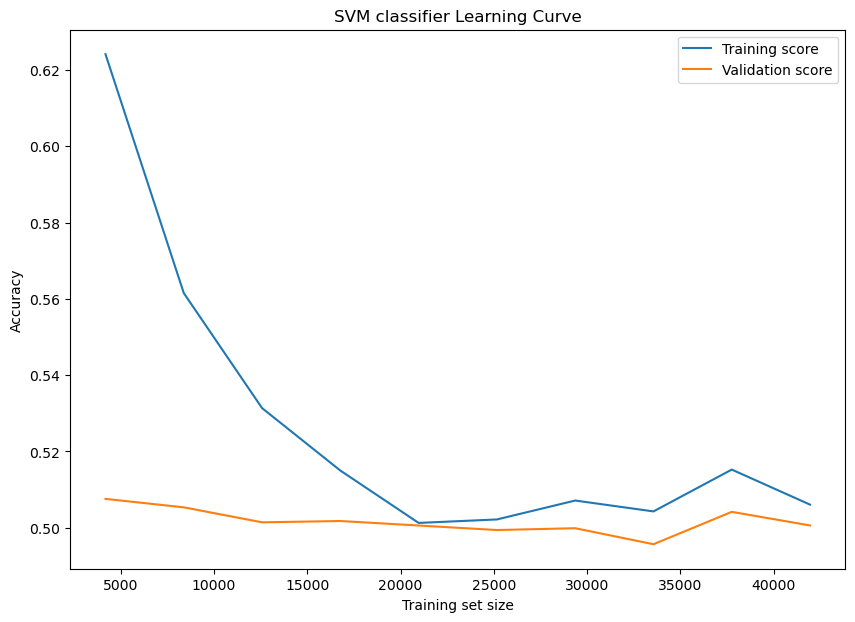

In [8]:
plt.figure(figsize=(10,7))
plt.plot(SVM_train_sizes, np.mean(SVM_train_scores, axis=1), label='Training score')
plt.plot(SVM_train_sizes, np.mean(SVM_valid_scores, axis=1), label='Validation score')
plt.ylabel('Accuracy')
plt.xlabel('Training set size')
plt.title('SVM classifier Learning Curve')
plt.legend()
plt.show()



In [6]:
svm_model = svm.LinearSVC()
svm_model.fit(train_dataset_image_Scaled, train_dataset_label)

y_test_hat = svm_model.predict(test_dataset_image_Scaled)
accuracy_svm_test = accuracy_score(test_dataset_label, y_test_hat)
print(f'Baseline model Test accuracy: {round(accuracy_svm_test * 100, 1)}% accuracy.')

y_test_hat = svm_model.predict(validation_dataset_image_Scaled)
accuracy_svm_validation = accuracy_score(validation_dataset_label, y_test_hat)
print(f'Baseline model Validation accuracy: {round(accuracy_svm_validation * 100, 1)}% accuracy.')

Baseline model Test accuracy: 48.8% accuracy.
Baseline model Validation accuracy: 51.2% accuracy.


c:\Users\mikae\anaconda3\envs\GPUtf\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [ ]:
#Boosting model

catboost = CatBoostClassifier(iterations=200, loss_function='CrossEntropy', eval_metric='Accuracy', 
                              random_seed=42,data_partition='FeatureParallel',early_stopping_rounds=20)
grid = {'learning_rate': [0.03,0.01,0.1, 0.2,0.4],
        'depth': [1,2,4,6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = catboost.randomized_search(grid,
                                                   X=train_dataset_image_Scaled,
                                                   y=train_dataset_label,
                                                   plot=True)

# # task_type="GPU"

In [ ]:
randomized_search_result 

{'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.1}

#Grayscale fit
'params': {'depth': 6, 'l2_leaf_reg': 7, 'learning_rate': 0.2},

{'depth': 10, 'l2_leaf_reg': 7, 'learning_rate': 0.1}

In [7]:
#Kør denne model

# catboost = CatBoostClassifier(iterations=500, learning_rate=0.2, depth=6,l2_leaf_reg=7, loss_function='CrossEntropy', eval_metric='Accuracy', random_seed=42,data_partition='FeatureParallel' )
# fitted_catboost = catboost.fit(train_dataset_image_Scaled, train_dataset_label,eval_set=(validation_dataset_image_Scaled, validation_dataset_label), use_best_model=True)


catboost = CatBoostClassifier(iterations=500, loss_function='CrossEntropy', eval_metric='Accuracy', random_seed=42,data_partition='FeatureParallel' )
fitted_catboost = catboost.fit(train_dataset_image_Scaled, train_dataset_label,eval_set=(validation_dataset_image_Scaled, validation_dataset_label), use_best_model=True)


0:	learn: 0.6568311	test: 0.6599512	best: 0.6599512 (0)	total: 117ms	remaining: 58.2s
1:	learn: 0.6874440	test: 0.6984127	best: 0.6984127 (1)	total: 223ms	remaining: 55.5s
2:	learn: 0.6993458	test: 0.7100122	best: 0.7100122 (2)	total: 329ms	remaining: 54.4s
3:	learn: 0.7097789	test: 0.7161172	best: 0.7161172 (3)	total: 434ms	remaining: 53.9s
4:	learn: 0.7137653	test: 0.7222222	best: 0.7222222 (4)	total: 540ms	remaining: 53.5s
5:	learn: 0.7178661	test: 0.7240537	best: 0.7240537 (5)	total: 643ms	remaining: 52.9s
6:	learn: 0.7190486	test: 0.7301587	best: 0.7301587 (6)	total: 749ms	remaining: 52.7s
7:	learn: 0.7214137	test: 0.7301587	best: 0.7301587 (6)	total: 851ms	remaining: 52.3s
8:	learn: 0.7246371	test: 0.7326007	best: 0.7326007 (8)	total: 953ms	remaining: 52s
9:	learn: 0.7258960	test: 0.7301587	best: 0.7326007 (8)	total: 1.05s	remaining: 51.7s
10:	learn: 0.7275554	test: 0.7368742	best: 0.7368742 (10)	total: 1.16s	remaining: 51.5s
11:	learn: 0.7294627	test: 0.7374847	best: 0.7374847 (

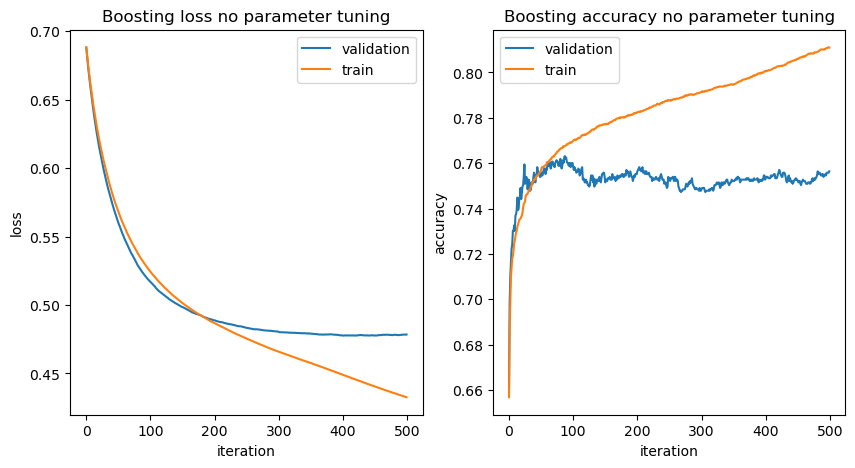

In [11]:


#from tsv file to dataframe

df_test = pd.read_csv(file_dir + r'\catboost_info\test_error.tsv', sep='\t')
df_train = pd.read_csv(file_dir + r'\catboost_info\learn_error.tsv', sep='\t')
#plot accuracy and loss from dataframe 


plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(df_test['CrossEntropy'])
plt.plot(df_train['CrossEntropy'])
plt.title('Boosting loss no parameter tuning')
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['validation', 'train'], loc='upper right')


plt.subplot(1,2,2)
plt.plot(df_test['Accuracy'])
plt.plot(df_train['Accuracy'])
plt.title('Boosting accuracy no parameter tuning')
plt.ylabel('accuracy')
plt.xlabel('iteration')
plt.legend(['validation', 'train'], loc='upper left')
plt.show()


In [9]:
#Catboost prediction on grayscale images 32x32
y_test_hat = fitted_catboost.predict(test_dataset_image_Scaled)
accuracy = accuracy_score(test_dataset_label, y_test_hat)
print(f'Baseline model test accuracy: {round(accuracy * 100, 1)}% accuracy.')

#Baseline model  test accuracy with fine tuning : 76.1% accuracy.
#Vi vælger catboost modelen grundet bedre accuracy på test set
#Baseline er catboost med 32x32 grayscale images

#Catbost predict on validation dataset
y_test_hat = fitted_catboost.predict(validation_dataset_image_Scaled)
accuracy = accuracy_score(validation_dataset_label, y_test_hat)
print(f'Baseline model validation accuracy: {round(accuracy * 100, 1)}% accuracy.')
# baseline model validation accuracy with tuning : 77.1% accuracy.

Baseline model test accuracy: 74.2% accuracy.
Baseline model validation accuracy: 76.3% accuracy.
